In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
# Load the training and testing datasets
train_essays = pd.read_csv("/content/Training_Essay_Data.csv")
test_essays = pd.read_csv("/content/y_train_large.csv")

In [ ]:
# Explore the training data
train_essays.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       29145 non-null  object
 1   generated  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB


In [ ]:
train_essays.head()


,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


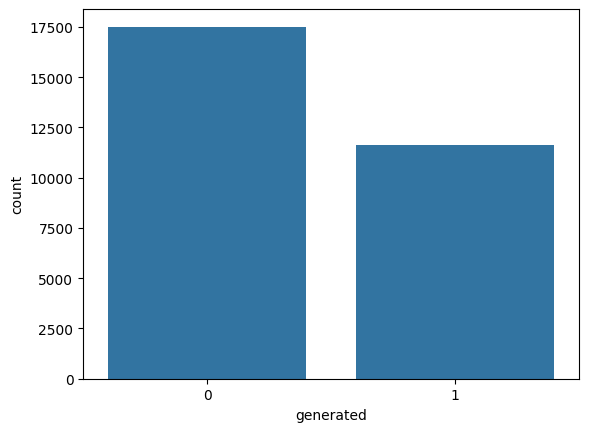

In [ ]:
# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    words = text.split()  # Tokenize
    words = [word.lower() for word in words if word.isalpha()]  # Lowercase and remove non-alphabetic words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

train_essays['clean_text'] = train_essays['text'].apply(clean_text)

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_essays['clean_text'], train_essays['generated'], test_size=0.2, random_state=42)

In [ ]:
# Tokenization and Encoding for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')

In [ ]:
# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

In [ ]:
# Create TensorDatasets
train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)
print(train_dataset)
print(val_dataset)

In [ ]:
# DataLoader for efficient processing
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,  # Adjust based on your system
    pin_memory=True  # Speeds up data transfer to GPU
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Define the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
epochs = 10

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

# Set gradient accumulation steps
accumulation_steps = 4

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i, batch in enumerate(train_loader):
        # Unpack the tuple
        input_ids, attention_mask, labels = batch

        # Move tensors to the device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass with mixed precision
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps  # Divide loss by accumulation steps
            total_loss += loss.item()

        # Backward pass with gradient accumulation
        scaler.scale(loss).backward()

        # Perform optimizer step after accumulating gradients
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.2f}")

KeyboardInterrupt: 

In [ ]:
  # Validation loop
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

In [ ]:
# Calculate validation accuracy
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy:.2f}")


In [ ]:
# Test data processing
test_inputs = tokenizer(test_essays['text'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Move input tensor to the same device as the model
test_inputs = {key: value.to(device) for key, value in test_inputs.items()}

print(test_inputs)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
# Assuming you have already loaded and preprocessed your test_essays DataFrame
# and the tokenizer and model

# Load test data
test_essays = pd.read_csv("/content/y_train_large.csv")

# Tokenize and encode test data
test_inputs = tokenizer(test_essays['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move input tensor to the same device as the model
test_inputs = {key: value.to(device) for key, value in test_inputs.items()}


# Create a TensorDataset and DataLoader (if you need batch processing)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'])
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) # Batch size is optional


# Set model to evaluation mode
model.eval()

# Store the results
test_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        test_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

# Add prediction to the dataframe
test_essays['predicted'] = test_preds
print(test_essays[['text','predicted']].head())

# Evaluation (if you have the true labels for the test set)
# Assuming you have test labels in test_essays['generated']
if 'generated' in test_essays.columns:
  test_accuracy = accuracy_score(test_essays['generated'], test_preds)
  print(f"Test Accuracy: {test_accuracy:.2f}")
  print(classification_report(test_essays['generated'], test_preds))
else:
    print("No labels provided for the test set, so accuracy can not be calculated.")

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import os

# Define the path to save the model
model_path = "/content/saved_model_Lvl1"

# Create the directory if it doesn't exist
os.makedirs(model_path, exist_ok=True)

# Save the model
model.save_pretrained(model_path)

# Save the tokenizer
tokenizer.save_pretrained(model_path)

print(f"Model and tokenizer saved to {model_path}")

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd

# Define the path to the model
model_path = "/content/saved_model"

# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example function to load a new text and make a prediction
def predict_new_text(new_text):
    # Preprocess the text
    stop_words = set(stopwords.words('english'))

    def clean_text(text):
      text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
      words = text.split()  # Tokenize
      words = [word.lower() for word in words if word.isalpha()]  # Lowercase and remove non-alphabetic words
      words = [word for word in words if word not in stop_words]  # Remove stop words
      return ' '.join(words)

    cleaned_text = clean_text(new_text)

    # Tokenize and encode the text
    inputs = tokenizer(cleaned_text, padding=True, truncation=True, return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}
    # Make the prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class

# Example usage:
new_text_example = "This essay was written by a human, I am sure"
predicted_class = predict_new_text(new_text_example)
print(f"The predicted class for the text is: {predicted_class}")

In [ ]:
import shutil

# Define the path to the saved model
model_path = "/content/saved_model"
zip_path = "/content/saved_model.zip"

# Compress the model directory
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', model_path)

# Download the zipped model directory
from google.colab import files
files.download(zip_path)